# Walabot recording

    Name:           walabot_RawRecording
    Parameters:     SetProfile, SetFilter, FrameRate(fps)
    Info:           Logs raw signals from radar antenna pairs, raw images and current unix time in nanosec.
                    Rate of measurement is currently not specified. Hence it depends on local processing power.
                    
    Based on:       'RawImage.py' of Walabot github project and "People and Fall Detection with Walabot" from
                    hackster.io

    @author: Lennart Aigner <lennart.aigner@tum.de>, Christian Lang <christian.lang@tum.de>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import time
import sys
import os
import pandas as pd
import numpy as np

if os.name == 'nt':
    from msvcrt import getch, kbhit
else:
    import curses

matplotlib.use('tkagg')

import WalabotAPI as wb

from IPython.display import clear_output

In [2]:
# Select scan arena
#             R             Phi          Theta
ARENA = [(40, 500, 4), (-60, 60, 5), (-15, 15, 5)]

In [3]:
# Init of Dataframe
dataset = pd.DataFrame()
# Star Walabot capture process
print("Initialize API")
wb.Init()
wb.Initialize()

# Check if a Walabot is connected
try:
    wb.ConnectAny()

except wb.WalabotError as err:
    print("Failed to connect to Walabot.\nerror code: " + str(err.code))
    sys.exit(1)

ver = wb.GetVersion()
print("Walabot API version: {}".format(ver))

print("Connected to Walabot")
wb.SetProfile(wb.PROF_SENSOR)

# Set scan arena
wb.SetArenaR(*ARENA[0])
wb.SetArenaPhi(*ARENA[1])
wb.SetArenaTheta(*ARENA[2])
print("Arena set")

# Set image filter
wb.SetDynamicImageFilter(wb.FILTER_TYPE_NONE)

Initialize API
Walabot API version: 1.2.2_1a20f5edc5cf4fada3b3002990052a300279b7f8
Connected to Walabot
Arena set


In [4]:
# Start calibration
wb.Start()
wb.StartCalibration()
while wb.GetStatus()[0] == wb.STATUS_CALIBRATING:
    wb.Trigger()

print("Calibration done!")

Calibration done!


###  For Sensor profile use Polar coordinates Arena 
(see Walabot_SetArenaR(), Walabot_SetArenaPhi()).
E.g.:
Phi = phiMin + i *(phiMax-phiMin) / (sizeX-1);
R = RMin + j *(RMax-RMin) / (sizeY-1);

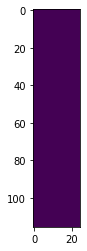

In [5]:
wb.Trigger
    
plt.imshow(np.array(wb.GetRawImageSlice()[0]))

In [6]:
namevar = time.strftime("%Y_%m_%d_%H_%M_%S")
start_namevar = namevar

In [7]:
dim1, dim2 = wb.GetRawImageSlice()[1:3]
try:
    pairs = wb.GetAntennaPairs()
    j=1
    #print(len(wb.GetAntennaPairs()))
    
    while True:
        # One iteration takes around 0.1 seconds
        wb.Trigger()
        try:

            raw_image, size_phi, size_r, slice_depth, power = wb.GetRawImageSlice()

            clear_output()
            print(np.array(raw_image).sum())
            
            sample_dict = {
                'timestamp': time.time_ns(),
                # 'raw_signals': raw_signals,
                'raw_image/img': raw_image,
                'raw_image/r': size_r,
                'raw_image/phi': size_phi,
                'raw_image/depth': slice_depth,
                'raw_image/power': power
                }

            dataset = dataset.append(sample_dict, ignore_index=True)
            #print(sample_dict["timestamp"])
        except:
            print(sys.exc_info())
        
        if j == 1000:
            dataset.iloc[-1000:].to_pickle("walabot_{}.pkl".format(namevar))
            namevar  = time.strftime("%Y_%m_%d_%H_%M_%S")
            j = 1
            
        time.sleep(0.2)
        j+=1
        
except KeyboardInterrupt:
    print('interrupted!')


0
interrupted!


In [8]:
dataset.to_pickle("walabot_{}.pkl".format(start_namevar))

In [9]:
wb.Stop()
wb.Disconnect()

print("Done!")

sys.exit(0)

Done!


SystemExit: 0

c:\users\tamar\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
dataset.shape

(288, 6)